
# Hebrew Study Notebook

In [1]:
import os, json
from pprint import pprint
import collections
from datetime import datetime
from IPython.display import display
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from iMahir import loadStudy

In [2]:
home_dir = os.path.expanduser('~/')
hebrew = os.path.join(home_dir, 'Documents/vocabulary/hebrew.json')

In [3]:
! date

Thu 21 Nov 2019 23:13:48 GMT


In [4]:
heb = loadStudy(hebrew)

preparing TF...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used



Session is resumed from 2019-11-21 17:15:33.201962.

hebrew ready for study.
this is session 7:
score 6: 2 terms
score 5: 18 terms
score 4: 37 terms
score 3: 147 terms
score 2: 18 terms
score 1: 20 terms
score 0: 100 terms
total: 342


In [5]:
heb.learn()

The following scores were changed 
2<-3 		 4
3->4 		 1
1->2 		 4
2->3 		 10
1<-2 		 1
0->1 		 4
0->3 		 3
0->2 		 1
4->5 		 9

duration:  1:01:41.734899

seconds per term: 10.82


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Notes

## Study Stats

### Size of Known Term Set (Scores 3-4)

In [6]:
sessions = [sd for sd in heb.set_data['stats'] if 'score_counts' in sd]
learned_lengths = [sum(s['score_counts'][scr] for scr in s['score_counts'] if int(scr) > 2) 
                       for s in sessions]
unlearned_lengths = [s['score_counts']['0'] for s in sessions]
dates = [datetime.strptime(sd['date'], '%Y-%m-%d %H:%M:%S.%f') for sd in sessions]
date_labels = [datetime.strftime(time, format='%d-%m_%H:%M') for time in dates]
date2nlearned = dict(zip(date_labels, learned_lengths)) # get dict for references
date2nunlearned = dict(zip(date_labels, unlearned_lengths))

# plot this data only with cutoff
cutoff = -30 # max amount
plt_sessions = sessions[cutoff:]
plt_learned = learned_lengths[cutoff:]
plt_unlearned = unlearned_lengths[cutoff:]
plt_dates = date_labels[cutoff:]

# calculate cycle lines
cycle_bounds = []
last_cycle = None
for i, sd in enumerate(plt_sessions):
    cycle = sd['cycle']
    last_cycle = cycle if not last_cycle else last_cycle
    if last_cycle != cycle:
        cycle_bounds.append(i-0.5)
        last_cycle = cycle

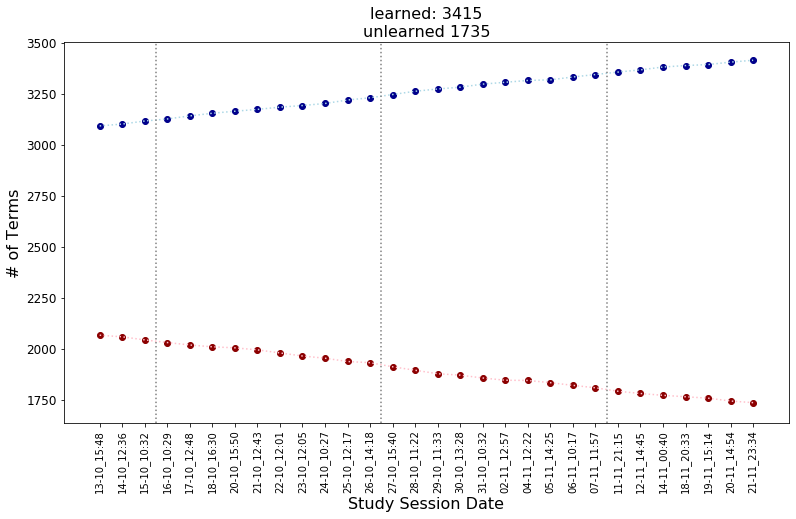

In [7]:
# make the plot
x = np.arange(len(plt_learned))
plt.figure(figsize=(13, 7))
plt.plot(x, plt_learned, linestyle='dotted', color='lightblue')
plt.scatter(x, plt_learned, color='darkblue')
plt.plot(x, plt_unlearned, linestyle='dotted', color='pink')
plt.scatter(x, plt_unlearned, color='darkred')
plt.xticks(x, plt_dates, rotation=90, size=10)
plt.yticks(size=12)
plt.ylabel('# of Terms', size=16)
plt.xlabel('Study Session Date', size=16)
plt.title(f'learned: {plt_learned[-1]}\nunlearned {plt_unlearned[-1]}', size=16)
for bound in cycle_bounds:
    plt.axvline(bound, color='grey', linestyle='dotted')
plt.show()

In [8]:
last_transition = plt_dates[int(cycle_bounds[-1] - 0.5)] # get date of last cycle switch
print('n-learned since last cycle:', plt_learned[-1] - date2nlearned[last_transition])

n-learned since last cycle: 70


### Unlearned Terms by Frequency

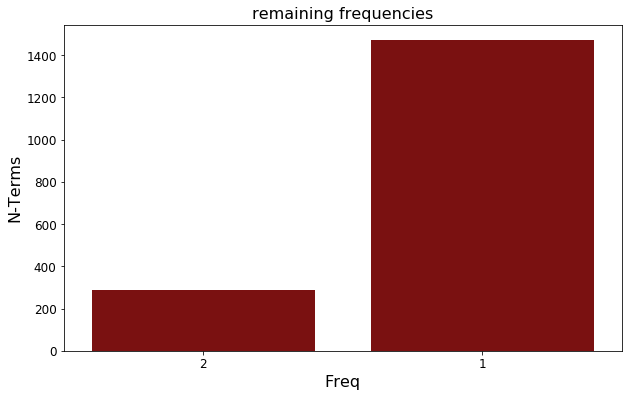

,0
2,287
1,1471


In [9]:
# get terms left to learn
to_learn = collections.Counter()
for i in heb.set_data['term_queues']['0']:
    term_lexs = heb.set_data['terms_dict'][i]['source_lexemes']
    for term in term_lexs:
        freq = heb.F.freq_lex.v(term)
        to_learn[freq] += 1           
to_learn = pd.DataFrame.from_dict(to_learn, orient='index').sort_values(by=0)

# make the plot
nbars = np.arange(to_learn.shape[0])
plt.figure(figsize=(10, 6))
sns.barplot(nbars, to_learn[0], color='darkred')
plt.xticks(nbars, labels=list(str(i) for i in to_learn.index), size=12)
plt.yticks(size=12)
plt.ylabel('N-Terms', size=16)
plt.xlabel('Freq', size=16)
plt.title(f'remaining frequencies', size=16)
plt.show()
display(to_learn)

In [10]:
results = []

for t,tdat in heb.set_data['terms_dict'].items():
    if (tdat['score'] == '0'
        and 2 in set(heb.F.freq_lex.v(l) for l in tdat['source_lexemes'])
        and 'verb' in set(heb.F.sp.v(l) for l in tdat['source_lexemes'])
       ):
        
        results.append((t, tdat))

len(results)

2

### Push Backup to Github

In [11]:
! cp /Users/cody/Documents/vocabulary/hebrew.json sample_vocab/.

In [12]:
! git add sample_vocab/.; git commit -m "Latest updates"

[master ca2a2ff] Latest updates
 1 file changed, 707 insertions(+), 662 deletions(-)


In [13]:
! git add study_HB.ipynb; git commit -m "Latest session"

[master 7147fc2] Latest session
 1 file changed, 40 insertions(+), 24 deletions(-)


In [14]:
! git push origin master

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 4 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 5.02 KiB | 428.00 KiB/s, done.
Total 7 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/codykingham/Mahir
   a2f1756..7147fc2  master -> master


## Goals


### Learn them all: 

I want to knock out the remaining unlearned terms within the next year, that is:

> **05 July 2019 – 05 July 2020**

In [24]:
year = 365
cycle_size = 10
total_unlearned = date2nunlearned['04-07_12:40']

# based on previous cycle, calculate the quota 2 learned ratio
zero_quota = 50
learnedincycle = date2nlearned['04-07_12:40'] - date2nlearned['26-06_13:52'] # how many I've done in a cycle with 50
quota2learned = zero_quota / learnedincycle
learned2quota = learnedincycle / zero_quota
print(f'The quota-to-learned ratio is: {quota2learned}')
print(f'The learned-to-quota ratio is: {learned2quota}')

The quota-to-learned ratio is: 1.0869565217391304
The learned-to-quota ratio is: 0.92


So 92% of terms in the zero quota were learned in this cycle period.

Let's see what's needed to knock out the remaining unlearned terms in a year.

In [25]:
(total_unlearned * quota2learned / year) * cycle_size

97.64740917212626

Thus, I need 98 terms per cycle.

### Future

Experiment with various cycle lengths in the future when all terms are learned.

In [30]:
total = plt_learned[-1] + plt_unlearned[-1]

total / 15 # cycle length of 15

343.73333333333335

In [31]:
total / 20 # cycle length 

257.8

In [32]:
total / 30 # cycle length

171.86666666666667